In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Load data 

In [29]:
# Load data
data = pd.read_csv("Data/All_data.csv").reset_index()

In [30]:
data = data.drop('index', axis=1)

In [31]:
data

,dato,togpunktlighed,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,koreplan_antal_planlagte_togfoelge_under_5_min_myldretid,koreplan_gns_planlagte_togfoelg_alle_min_myldretid,...,dsb_tgf_relative_sygdom,dsb_lkf_fte,dsb_lkf_sygdom,dsb_lkf_relative_sygdom,dsb_haandvaerker,dsb_fravaer,dsb_relative_fravaer,mean_temp,mean_wind_speed,acc_precip
0,2016-01-01,0.941,5.0,2.0,0.41,5.0,0.41,0.0,0.0,150.00,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
1,2016-01-01,0.882,8.0,2.0,0.82,8.0,0.82,0.0,0.0,85.57,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
2,2016-01-01,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
3,2016-01-01,0.941,13.0,3.0,1.33,13.0,1.33,0.0,0.0,50.00,...,0.024419,186.132726,20.680000,0.111104,482.0,4.594,0.047412,4.2,2.5,0.0
4,2016-01-01,0.971,16.0,4.0,1.51,16.0,1.51,0.0,3.0,46.00,...,0.024419,186.132726,20.680000,0.111104,482.0,4.594,0.047412,4.2,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199441,2022-12-31,0.960,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000000,29.000000,22.520000,0.776552,493.0,6.379,0.040891,7.5,5.1,8.4
199442,2022-12-31,1.000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.039799,102.000000,23.799999,0.233333,493.0,6.379,0.040891,6.6,3.9,4.4
199443,2022-12-31,0.789,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.006712,97.000000,24.270000,0.250206,493.0,6.379,0.040891,7.6,4.5,7.2
199444,2022-12-31,0.943,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.006712,97.000000,24.270000,0.250206,493.0,6.379,0.040891,7.6,4.5,7.2


In [32]:
# Check for NaN values
np.sum(np.sum(data.isna(), axis=1))

0

In [33]:
# Make data a datetime object
data['dato'] = pd.to_datetime(data['dato'], format='%Y-%m-%d').astype('datetime64[us]')

# Delete zeros

In [34]:
def visualize_strækning(data_start, strækning, save=False, ending=''):
    strækning_data = data_start[data_start['visualiseringskode'] == strækning]
    data_strækning_daily = strækning_data.groupby('dato').mean().reset_index()
    print(strækning_data.shape[0])
    plt.plot(data_strækning_daily['dato'], data_strækning_daily['togpunktlighed'])
    plt.grid()
    plt.title(f'Route {strækning}')
    if save:
        plt.tight_layout()
        plt.savefig(f'Results/Data_Cleaning_DeleteZeros{strækning}{ending}')
    plt.show()

In [35]:
# NOT PER DAY.

from datetime import datetime, timedelta

def delete_zeros(strækning, x, save=False):
    strækning_data = data[data['visualiseringskode'] == strækning].copy()  # Ensure a copy of the DataFrame is created
    
    strækning_data.loc[:,'zero_togpunktlighed'] = (strækning_data.loc[:,'togpunktlighed'] == 0).astype(int)
    strækning_data.loc[:,'consecutive_zeros'] = strækning_data.groupby((strækning_data.loc[:,'zero_togpunktlighed'] != strækning_data.loc[:,'zero_togpunktlighed'].shift()).cumsum())['zero_togpunktlighed'].transform('cumsum')
    
    # Find dates with more than x consecutive zeros
    dates_with_more_than_x_zeros = strækning_data[strækning_data['consecutive_zeros'] > x]['dato'].unique()
    # Find dates containing both zeros and ones
    dates_with_ones = strækning_data[strækning_data['zero_togpunktlighed'] == 0]['dato'].unique()
    # Exclude dates with both zeros and ones from dates_with_more_than_x_zeros
    dates_with_more_than_x_zeros = np.setdiff1d(dates_with_more_than_x_zeros, dates_with_ones)
    
    # Find the first index of each sequence of x or more consecutive zeros
    first_indexes = strækning_data[strækning_data['consecutive_zeros'] == x].groupby((strækning_data['consecutive_zeros'] != strækning_data['consecutive_zeros'].shift()).cumsum()).head(1).index
    
    # Remove the rows leading up to the first zero in each sequence of x or more consecutive zeros
    for idx in first_indexes:
        first_index = strækning_data.index.get_loc(idx)
        for index in strækning_data.index[first_index-x-1:first_index]:
            if (strækning_data.loc[idx,'dato'] - strækning_data.loc[index,'dato'] <= timedelta(days=x)) and (strækning_data.loc[index,'togpunktlighed'] == 0):
                dates_with_more_than_x_zeros = np.append(dates_with_more_than_x_zeros, strækning_data.loc[index,'dato'])
    
    # Filter out rows with more than x consecutive zeros
    strækning_data_filtered = strækning_data[~strækning_data['dato'].isin(dates_with_more_than_x_zeros)]
    strækning_data_filtered = strækning_data_filtered.drop(columns=['zero_togpunktlighed', 'consecutive_zeros'])
    visualize_strækning(data, strækning, save=save, ending='Before')
    visualize_strækning(strækning_data_filtered, strækning, save=save, ending='After')
    return strækning_data_filtered

5114


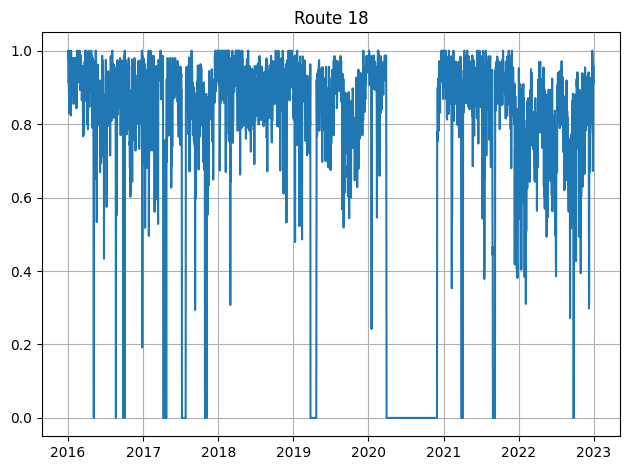

4464


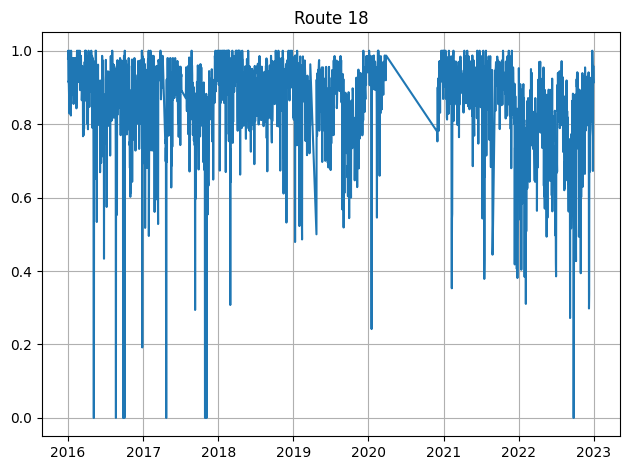

In [36]:
strækning_data_filtered = delete_zeros(18, 10, save=True)

5114


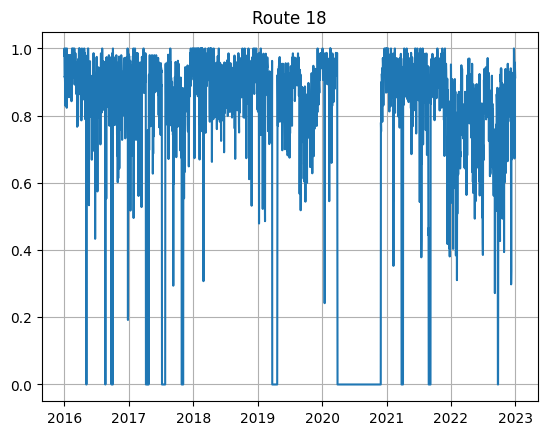

4464


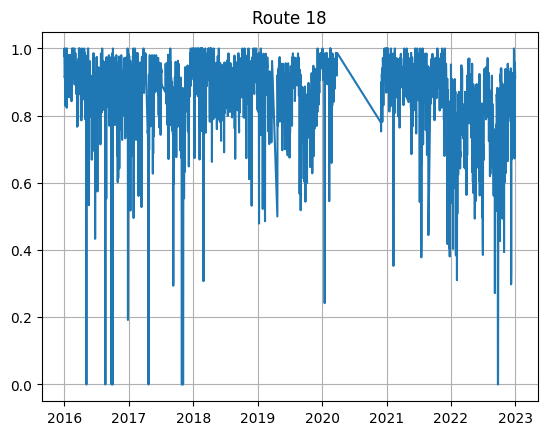

7671


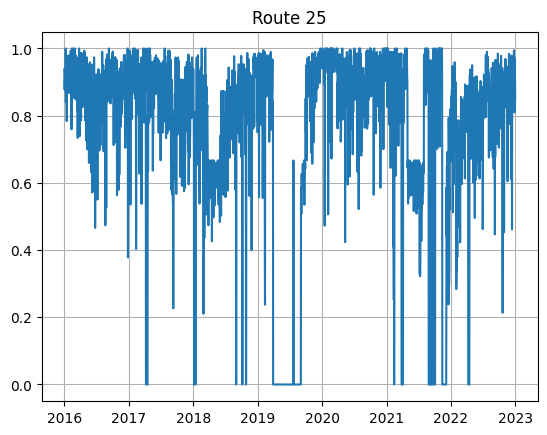

7020


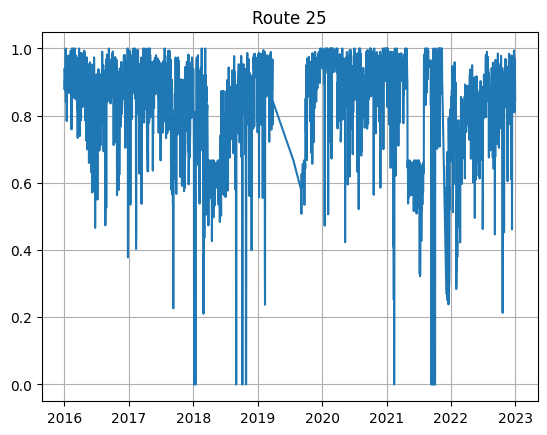

5114


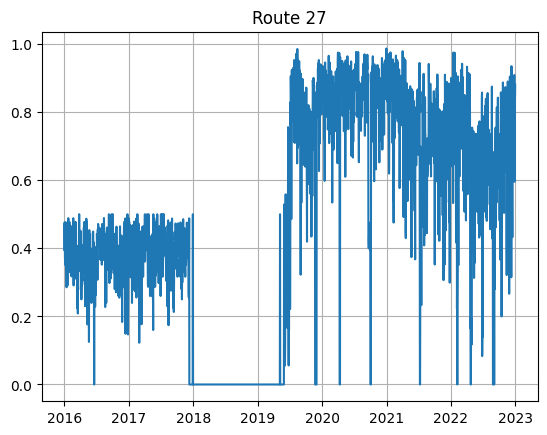

4018


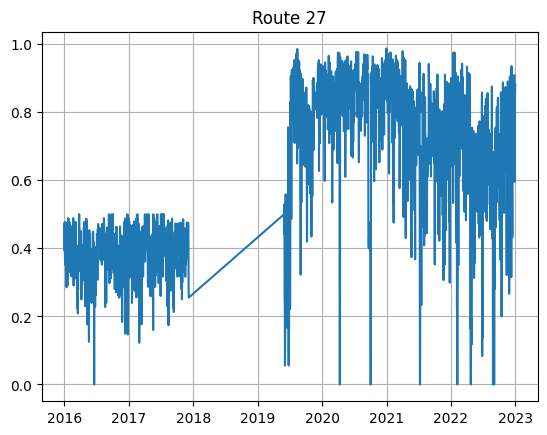

In [25]:
# BaneDanmark laver sporarbejde på:
# - strækning 18 i 2020
# - strækning 25 i 2019
# - strækning 27 i 2018-2019
for strækning in [18, 25, 27]:
    strækning_data_filtered = delete_zeros(strækning, 10)
    data.loc[data['visualiseringskode'] == strækning, :] = strækning_data_filtered
    data = data.dropna()

# Delete railway lines no longer operated by DSB

In [11]:
# Disse strækninger er udbydt? Ja
# - strækning 1 i 2021 - væk. 
# - strækning 26
# - strækning 28
for strækning in [1, 26, 28]:
    data = data[data['visualiseringskode'] != strækning]
# Check if deleted:
sum(data['visualiseringskode'] == 26)

0

# Lagged data

In [12]:
important_features = ['dsb_open_errors_a', 'dsb_open_errors_b', 'dsb_open_errors_c', 'dsb_open_errors_d', 
                      'dsb_0_1', 'dsb_lkf_sygdom', 'dsb_tgf_sygdom', 
                      'dsb_nedformeringer', 'dsb_opformeringer', 'dsb_event_count',
                      'dsb_station_passengers_in', 'dsb_station_passengers_out',
                      'mean_temp', 'mean_wind_speed', 'acc_precip',
                      'togpunktlighed'] # Weather data added

In [13]:
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values

lagged_dfs = []

for strækning, station in combinations:
    data_temp = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]
    data_temp = data_temp.groupby('dato').mean() # Does not matter that it is mean - same number of rows just need aggregation function. 
    for feature in important_features:
        for lag in range(1,5):
            data_temp[f'{feature}_lagged{lag}'] = data_temp[feature].shift(lag)
    lagged_dfs.append(data_temp)

lagged_data = pd.concat(lagged_dfs)


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_8460/3296121241.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_temp[f'{feature}_lagged{lag}'] = data_temp[feature].shift(lag)
/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_8460/3296121241.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_temp[f'{feature}_lagged{lag}'] = data_temp[feature].shift(lag)
/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_8460/3296121241.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is

In [14]:
data.shape

(174036, 213)

In [15]:
lagged_data.shape

(174036, 276)

In [16]:
lagged_data

,togpunktlighed,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,koreplan_antal_planlagte_togfoelge_under_5_min_myldretid,koreplan_gns_planlagte_togfoelg_alle_min_myldretid,koreplan_stdafv_planlagte_togfoelg_alle_min_myldretid,...,mean_wind_speed_lagged3,mean_wind_speed_lagged4,acc_precip_lagged1,acc_precip_lagged2,acc_precip_lagged3,acc_precip_lagged4,togpunktlighed_lagged1,togpunktlighed_lagged2,togpunktlighed_lagged3,togpunktlighed_lagged4
dato,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.882,8.0,2.0,0.82,8.0,0.82,0.0,0.0,85.57,129.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,0.897,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,NaN,NaN,0.0,NaN,NaN,NaN,0.882,NaN,NaN,NaN
2016-01-03,0.824,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,NaN,NaN,0.0,0.0,NaN,NaN,0.897,0.882,NaN,NaN
2016-01-04,0.900,17.0,4.0,0.63,18.0,0.63,0.0,0.0,40.29,86.88,...,2.9,NaN,0.0,0.0,0.0,NaN,0.824,0.897,0.882,NaN
2016-01-05,0.860,17.0,3.0,0.41,17.0,0.41,0.0,0.0,42.81,89.21,...,9.3,2.9,0.0,0.0,0.0,0.0,0.900,0.824,0.897,0.882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.809,22.0,1.0,0.00,22.0,0.52,0.0,0.0,67.08,118.74,...,3.7,3.3,2.2,3.7,0.3,0.0,0.967,0.969,0.982,0.855
2022-12-28,0.970,22.0,1.0,0.00,22.0,0.82,0.0,0.0,66.55,118.80,...,4.1,3.7,0.4,2.2,3.7,0.3,0.809,0.967,0.969,0.982
2022-12-29,0.952,20.0,1.0,0.00,20.0,0.82,0.0,0.0,73.94,123.76,...,5.3,4.1,9.3,0.4,2.2,3.7,0.970,0.809,0.967,0.969


# One-Hot-Encoding for categorical variables

In [17]:
# Not relevant. 

# Scale features

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
not_transformed = ['dato', 'togpunktlighed', 'visualiseringskode', 'station']
columns_to_scale = [col for col in data.columns if col not in not_transformed]

data_t = scaler.fit_transform(data.loc[:, columns_to_scale])
data_t = pd.DataFrame(data_t, columns=columns_to_scale) 
data_t

,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,koreplan_antal_planlagte_togfoelge_under_5_min_myldretid,koreplan_gns_planlagte_togfoelg_alle_min_myldretid,koreplan_stdafv_planlagte_togfoelg_alle_min_myldretid,koreplan_antal_planlagte_unik_tognr_godstog_myldretid,...,dsb_tgf_relative_sygdom,dsb_lkf_fte,dsb_lkf_sygdom,dsb_lkf_relative_sygdom,dsb_haandvaerker,dsb_fravaer,dsb_relative_fravaer,mean_temp,mean_wind_speed,acc_precip
0,0.049080,0.1250,0.308271,0.043011,0.110961,0.000000,0.000000,0.142617,0.409889,0.0,...,0.000000,0.146547,0.000000,0.000000,0.692884,0.068160,0.076218,0.382979,0.154762,0.000000
1,0.079755,0.1875,0.500000,0.069892,0.179973,0.000000,0.000000,0.083333,0.340175,0.0,...,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218,0.401596,0.130952,0.000000
2,0.098160,0.2500,0.567669,0.086022,0.204330,0.000000,0.027778,0.076667,0.299823,0.0,...,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218,0.401596,0.130952,0.000000
3,0.147239,0.2500,0.154135,0.134409,0.158322,0.026316,0.000000,0.097200,0.360763,0.0,...,0.101714,0.115067,0.000000,0.000000,0.692884,0.068160,0.076218,0.385638,0.166667,0.005891
4,0.030675,0.0625,0.154135,0.026882,0.055480,0.000000,0.000000,0.250000,0.570125,0.0,...,0.101714,0.115067,0.000000,0.000000,0.692884,0.068160,0.076218,0.385638,0.166667,0.005891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174031,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.062961,0.040156,0.104939,0.734082,0.099190,0.063604,0.489362,0.285714,0.123711
174032,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.155368,0.221449,0.042439,0.031532,0.734082,0.099190,0.063604,0.465426,0.214286,0.064801
174033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604,0.492021,0.250000,0.106038
174034,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604,0.492021,0.250000,0.106038


In [19]:
data_t.shape

(174036, 209)

In [20]:
data.loc[:,not_transformed].shape

(174036, 4)

In [21]:
data.reset_index(drop=True, inplace=True) # So it concatenates properly
data_t.reset_index(drop=True, inplace=True) # So it concatenates properly

data_transformed = pd.concat([data.loc[:,not_transformed], data_t], axis=1)
data_transformed

,dato,togpunktlighed,visualiseringskode,station,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,...,dsb_tgf_relative_sygdom,dsb_lkf_fte,dsb_lkf_sygdom,dsb_lkf_relative_sygdom,dsb_haandvaerker,dsb_fravaer,dsb_relative_fravaer,mean_temp,mean_wind_speed,acc_precip
0,2016-01-01,0.882,2.0,0.0,0.049080,0.1250,0.308271,0.043011,0.110961,0.000000,...,0.000000,0.146547,0.000000,0.000000,0.692884,0.068160,0.076218,0.382979,0.154762,0.000000
1,2016-01-01,0.941,2.0,2.0,0.079755,0.1875,0.500000,0.069892,0.179973,0.000000,...,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218,0.401596,0.130952,0.000000
2,2016-01-01,0.971,9.0,2.0,0.098160,0.2500,0.567669,0.086022,0.204330,0.000000,...,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218,0.401596,0.130952,0.000000
3,2016-01-01,0.926,10.0,3.0,0.147239,0.2500,0.154135,0.134409,0.158322,0.026316,...,0.101714,0.115067,0.000000,0.000000,0.692884,0.068160,0.076218,0.385638,0.166667,0.005891
4,2016-01-01,1.000,24.0,3.0,0.030675,0.0625,0.154135,0.026882,0.055480,0.000000,...,0.101714,0.115067,0.000000,0.000000,0.692884,0.068160,0.076218,0.385638,0.166667,0.005891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174031,2022-12-31,0.960,8.0,44.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.062961,0.040156,0.104939,0.734082,0.099190,0.063604,0.489362,0.285714,0.123711
174032,2022-12-31,1.000,3.0,45.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.155368,0.221449,0.042439,0.031532,0.734082,0.099190,0.063604,0.465426,0.214286,0.064801
174033,2022-12-31,0.789,5.0,46.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604,0.492021,0.250000,0.106038
174034,2022-12-31,0.943,9.0,46.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604,0.492021,0.250000,0.106038


In [22]:
from sklearn.preprocessing import MinMaxScaler
# Same for lagged data:
scaler = MinMaxScaler()
not_transformed = ['dato', 'togpunktlighed', 'visualiseringskode', 'station']
columns_to_scale = [col for col in lagged_data.columns if col not in not_transformed and not any(col.startswith(prefix) for prefix in not_transformed)] # Also avoid the lagged features

data_t = scaler.fit_transform(lagged_data.loc[:, columns_to_scale])
data_t = pd.DataFrame(data_t, columns=columns_to_scale) 
data_t

,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,koreplan_antal_planlagte_togfoelge_under_5_min_myldretid,koreplan_gns_planlagte_togfoelg_alle_min_myldretid,koreplan_stdafv_planlagte_togfoelg_alle_min_myldretid,koreplan_antal_planlagte_unik_tognr_godstog_myldretid,...,mean_temp_lagged3,mean_temp_lagged4,mean_wind_speed_lagged1,mean_wind_speed_lagged2,mean_wind_speed_lagged3,mean_wind_speed_lagged4,acc_precip_lagged1,acc_precip_lagged2,acc_precip_lagged3,acc_precip_lagged4
0,0.049080,0.1250,0.308271,0.043011,0.110961,0.0,0.0,0.142617,0.409889,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,NaN,NaN,0.154762,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,NaN,NaN,0.535714,0.154762,NaN,NaN,0.000000,0.000000,NaN,NaN
3,0.104294,0.2500,0.236842,0.096774,0.085250,0.0,0.0,0.067150,0.275181,0.0,...,0.382979,NaN,0.589286,0.535714,0.154762,NaN,0.000000,0.000000,0.000000,NaN
4,0.104294,0.1875,0.154135,0.091398,0.055480,0.0,0.0,0.071350,0.282560,0.0,...,0.305851,0.382979,0.488095,0.589286,0.535714,0.154762,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174031,0.134969,0.0625,0.000000,0.118280,0.070365,0.0,0.0,0.111800,0.376093,0.0,...,0.340426,0.377660,0.297619,0.226190,0.202381,0.178571,0.032401,0.054492,0.004418,0.000000
174032,0.134969,0.0625,0.000000,0.118280,0.110961,0.0,0.0,0.110917,0.376283,0.0,...,0.393617,0.340426,0.458333,0.297619,0.226190,0.202381,0.005891,0.032401,0.054492,0.004418
174033,0.122699,0.0625,0.000000,0.107527,0.110961,0.0,0.0,0.123233,0.391993,0.0,...,0.420213,0.393617,0.488095,0.458333,0.297619,0.226190,0.136966,0.005891,0.032401,0.054492
174034,0.116564,0.0625,0.000000,0.102151,0.055480,0.0,0.0,0.131517,0.405866,0.0,...,0.385638,0.420213,0.523810,0.488095,0.458333,0.297619,0.047128,0.136966,0.005891,0.032401


In [23]:
# Not transformed data
lagged_columns_to_include = [col for col in lagged_data.columns if any(col.startswith(prefix) for prefix in not_transformed)]
lagged_data_subset = lagged_data[lagged_columns_to_include].reset_index()
# Transformed data
data_t.reset_index(drop=True, inplace=True) # So it concatenates properly
# Concatenate
data_lagged_transformed = pd.concat([lagged_data_subset, data_t], axis=1)
data_lagged_transformed

,dato,togpunktlighed,station,visualiseringskode,togpunktlighed_lagged1,togpunktlighed_lagged2,togpunktlighed_lagged3,togpunktlighed_lagged4,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,...,mean_temp_lagged3,mean_temp_lagged4,mean_wind_speed_lagged1,mean_wind_speed_lagged2,mean_wind_speed_lagged3,mean_wind_speed_lagged4,acc_precip_lagged1,acc_precip_lagged2,acc_precip_lagged3,acc_precip_lagged4
0,2016-01-01,0.882,0.0,2.0,NaN,NaN,NaN,NaN,0.049080,0.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,0.897,0.0,2.0,0.882,NaN,NaN,NaN,0.000000,0.0000,...,NaN,NaN,0.154762,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,2016-01-03,0.824,0.0,2.0,0.897,0.882,NaN,NaN,0.000000,0.0000,...,NaN,NaN,0.535714,0.154762,NaN,NaN,0.000000,0.000000,NaN,NaN
3,2016-01-04,0.900,0.0,2.0,0.824,0.897,0.882,NaN,0.104294,0.2500,...,0.382979,NaN,0.589286,0.535714,0.154762,NaN,0.000000,0.000000,0.000000,NaN
4,2016-01-05,0.860,0.0,2.0,0.900,0.824,0.897,0.882,0.104294,0.1875,...,0.305851,0.382979,0.488095,0.589286,0.535714,0.154762,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174031,2022-12-27,0.809,47.0,25.0,0.967,0.969,0.982,0.855,0.134969,0.0625,...,0.340426,0.377660,0.297619,0.226190,0.202381,0.178571,0.032401,0.054492,0.004418,0.000000
174032,2022-12-28,0.970,47.0,25.0,0.809,0.967,0.969,0.982,0.134969,0.0625,...,0.393617,0.340426,0.458333,0.297619,0.226190,0.202381,0.005891,0.032401,0.054492,0.004418
174033,2022-12-29,0.952,47.0,25.0,0.970,0.809,0.967,0.969,0.122699,0.0625,...,0.420213,0.393617,0.488095,0.458333,0.297619,0.226190,0.136966,0.005891,0.032401,0.054492
174034,2022-12-30,0.915,47.0,25.0,0.952,0.970,0.809,0.967,0.116564,0.0625,...,0.385638,0.420213,0.523810,0.488095,0.458333,0.297619,0.047128,0.136966,0.005891,0.032401


# Save cleaned data (two datasets)

In [56]:
data_transformed.to_csv('Data/Cleaned_data.csv', index=False)

In [57]:
data_lagged_transformed.to_csv('Data/Cleaned_lagged_data.csv', index=False)

In [58]:
important_features.pop()
for i, feature in enumerate(['dato', 'togpunktlighed', 'visualiseringskode', 'station']):
    important_features.insert(i, feature)

In [59]:
important_features

['dato',
 'togpunktlighed',
 'visualiseringskode',
 'station',
 'dsb_open_errors_a',
 'dsb_open_errors_b',
 'dsb_open_errors_c',
 'dsb_open_errors_d',
 'dsb_0_1',
 'dsb_lkf_sygdom',
 'dsb_tgf_sygdom',
 'dsb_nedformeringer',
 'dsb_opformeringer',
 'dsb_event_count',
 'dsb_station_passengers_in',
 'dsb_station_passengers_out',
 'mean_temp',
 'mean_wind_speed',
 'acc_precip']

In [30]:
data_transformed[important_features].to_csv('Data/Cleaned_simple_data.csv', index=False)

In [123]:
important_and_lagged_cols = [col for col in data_lagged_transformed.columns if any(col.startswith(prefix) for prefix in important_features)]
data_lagged_transformed[important_and_lagged_cols].to_csv('Data/Cleaned_simple_lagged_data.csv', index=False)